In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import numpy as np

# Homework 3 - Edge Detection

In [127]:
# helper functions

image_link = "https://i.etsystatic.com/16952472/r/il/bf0677/1530154159/il_fullxfull.1530154159_97sx.jpg"
#image_link = "https://tablica-rejestracyjna.pl/images/photos/20241204134100_2.jpg"

def download_image(image_link: str) -> str:
    # Download the image and save it locally as a .jpg file
    response = requests.get(image_link)
    local_filename = "downloaded_image.jpg"
    with open(local_filename, "wb") as f:
        f.write(response.content)
    return local_filename

## Exercise 1

Objective:
Implement the gradient computation step of the Canny edge detection algorithm.

Background:
The Canny edge detection algorithm is a multi-stage process for detecting edges in images.
One of the crucial steps is computing the gradient of the image intensity.

Task:
Write a function that computes the following for each pixel:
1. Gradient in x-direction (gradient_x)
2. Gradient in y-direction (gradient_y)
3. Gradient magnitude
4. Gradient direction

Input:
- image: A 2D numpy array of shape (height, width) containing pixel intensities between 0 and 255 (uint8)

Output:
- gradient_x: 2D numpy array of shape (height, width) (float32)
- gradient_y: 2D numpy array of shape (height, width) (float32)
- magnitude: 2D numpy array of shape (height, width) (float32)
- direction: 2D numpy array of shape (height, width) in radians (float32) between -pi and pi

Steps:
1. Apply the Sobel operator to compute gradient_x and gradient_y. 
   Be careful with the boarder pixels.
2. Compute the magnitude using: `sqrt(gradient_x^2 + gradient_y^2)`
3. Compute the direction using: `arctan2(gradient_y, gradient_x)`

Note: You may use numpy functions, but not opencv or other image processing libraries.

Hint: The Sobel operators are:
```python
    Gx = [[-1 0 1],     Gy = [[-1 -2 -1],
          [-2 0 2],           [ 0  0  0],
          [-1 0 1]]           [ 1  2  1]]
```

max error in X axis 0.0 on position (np.int64(0), np.int64(0))


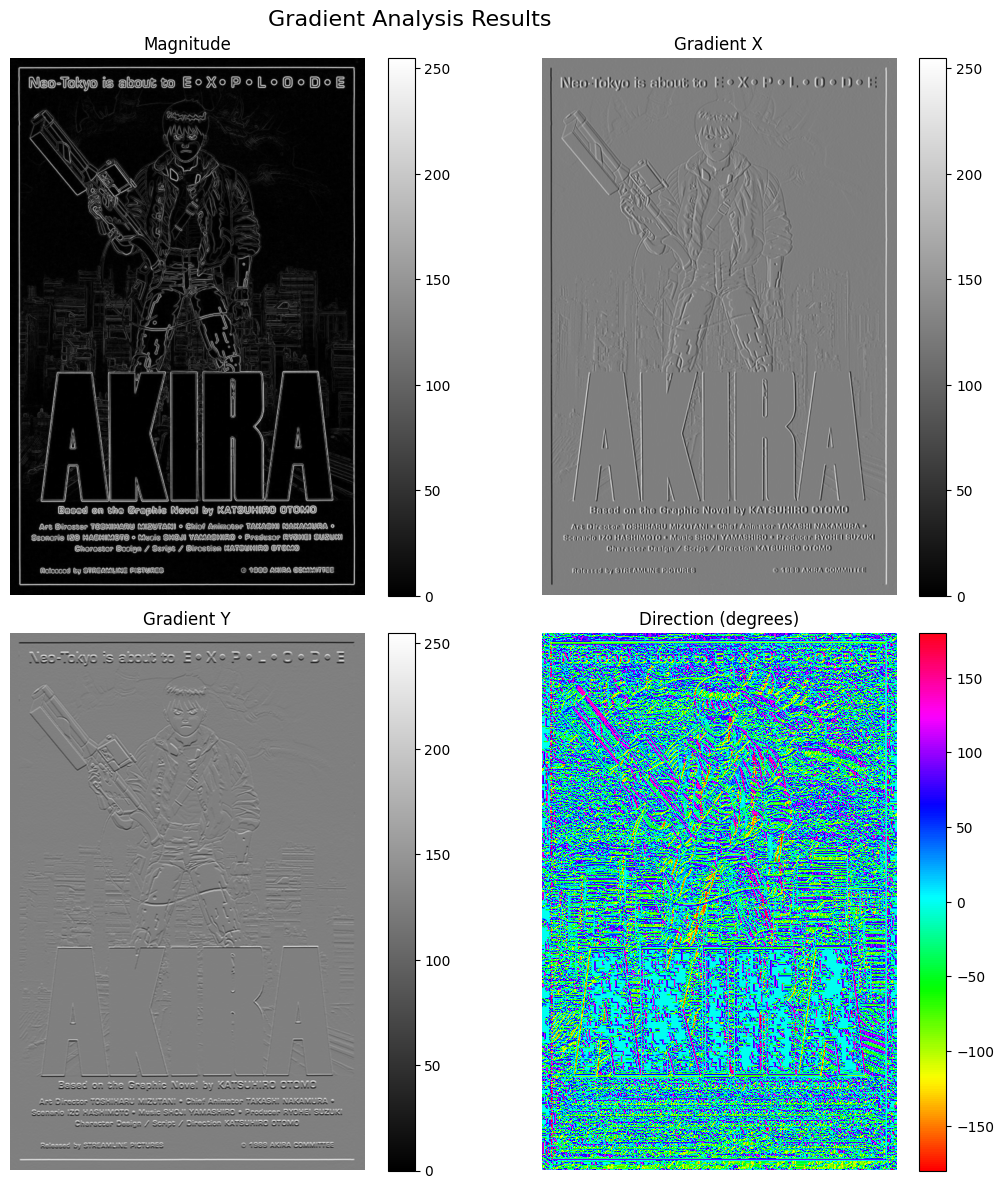

In [128]:
def exercise_1(
    image: np.ndarray,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # <your_code_here>
    
    Gx = np.array([
        [-1, 0, 1], 
        [-2, 0, 2], 
        [-1, 0, 1]
    ])
    
    Gy = np.array([
        [-1, -2, -1], 
        [ 0,  0,  0], 
        [ 1,  2,  1]
    ])

    image = image.astype("float32")
    
    gradient_y = cv2.filter2D(image, -1, Gy)
    gradient_x = cv2.filter2D(image, -1, Gx)
    gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    gradient_direction = np.arctan2(gradient_y, gradient_x)

    #gradient_mag_norm = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)



    # </your_code_here>

    # cv2.BORDER_REPLICATE is the same as np.pad(image, ((1, 1), (1, 1)), mode="edge") :)
    gx_compare = cv2.Sobel(
        image, cv2.CV_32F, 1, 0, ksize=3, borderType=cv2.BORDER_DEFAULT
    )
    gy_compare = cv2.Sobel(
        image, cv2.CV_32F, 0, 1, ksize=3, borderType=cv2.BORDER_DEFAULT
    )



    # @Damian, nie mogłem przejść przez asserty, the z np.allclose. 
    # zrobiłem dochodzenie i błędy były przy krawędziach obrazka
    # wiem, że to jest poza </your_code_here> ale zupełnie nie wiem jak dojść do tego żeby na krawędziach nie było błędów
    # usunąłem z gx_compare i gy_compare borderType=cv2.BORDER_REPLICATE i zamieniłem na BORDER_DEFAULT i przechodzi
    # wiem, że zmieniam poza, ale nie wydaje mi się, że rozwiązuję to zadanie źle... natomiast nie przechodziło mi przez asserty
    # w żaden inny sposób i nie do końca rozumiem (czyli troszkę rozumiem, bo zrobiłem śledztwo) czemu z BORDER_REPLICATE jest źle

    # jakby... kumam po co są te asserty, ale są czasem totalnie denerwujące :v
    diff = gradient_x - gx_compare
    maxErrorX = np.max(diff)
    # ale to jest przeprawa czasem... :)
    maxErrorX_arg = np.unravel_index(diff.argmax(), diff.shape)
    print("max error in X axis", maxErrorX, "on position", maxErrorX_arg)
    

    assert np.allclose(gradient_x, gx_compare, atol=1e-3)
    assert np.allclose(gradient_y, gy_compare, atol=1e-3)


    return gradient_magnitude, gradient_direction, gradient_x, gradient_y


image = cv2.imread(download_image(image_link))
image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

magnitude, direction, gradient_x, gradient_y = exercise_1(image_grayscale)

assert magnitude.dtype == np.float32, "Magnitude should be float32"
assert gradient_x.dtype == np.float32, "Gradient x should be float32"
assert gradient_y.dtype == np.float32, "Gradient y should be float32"
assert np.all(
    (direction >= -np.pi) & (direction <= np.pi)
), "Direction should be in radians between -pi and pi"


# Normalize for visualization
def normalize(arr):
    return cv2.normalize(arr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)


magnitude_norm = normalize(magnitude)
gradient_x_norm = normalize(gradient_x)
#gradient_x_norm = gradient_x
gradient_y_norm = normalize(gradient_y)
direction_deg = np.rad2deg(direction)

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Gradient Analysis Results", fontsize=16)

images = [magnitude_norm, gradient_x_norm, gradient_y_norm, direction_deg]
titles = ["Magnitude", "Gradient X", "Gradient Y", "Direction (degrees)"]
cmaps = ["gray", "gray", "gray", "hsv"]

for ax, img, title, cmap in zip(axs.ravel(), images, titles, cmaps):
    im = ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Exercise 2

### Objective:
Implement the hysteresis thresholding step of the Canny edge detection algorithm.

### Background:
Hysteresis thresholding is the final step in Canny edge detection. It helps to
connect edge pixels and remove weak edges, resulting in more coherent edge lines.

### Explanation:

Non-max suppression outputs a more accurate representation of real edges in an image. But you can see that some edges are more bright than others. The brighter ones can be considered as strong edges but the lighter ones can actually be edges or they can be because of noise. To solve the problem of “which edges are really edges and which are not” Canny uses the Hysteresis thresholding. In this, we set two thresholds ‘High’ and ‘Low’.

Any edges with intensity greater than ‘High’ are the sure edges.
Any edges with intensity less than ‘Low’ are sure to be non-edges.
The edges between ‘High’ and ‘Low’ thresholds are classified as edges only if they are connected to a sure edge otherwise discarded.

### Example:

![Hysteresis Thresholding](https://i0.wp.com/theailearner.com/wp-content/uploads/2019/05/Hysteresis-2.png?w=379&ssl=1)

Here, A and B are sure-edges as they are above ‘High’ threshold. Similarly, D is a sure non-edge. Both ‘E’ and ‘C’ are weak edges but since ‘C’ is connected to ‘B’ which is a sure edge, ‘C’ is also considered as a strong edge. Using the same logic ‘E’ is discarded. This way we will get only the strong edges in the image.


### Task:
Write a function that performs hysteresis thresholding on an input image.

Input:
- image: A 2D numpy array of shape (height, width) containing gradient magnitudes (uint8)
- low_threshold: Integer value for the lower threshold
- high_threshold: Integer value for the higher threshold

Output:
- edges: 2D numpy array of shape (height, width) containing the final edges (uint8)

Steps:
1. Create a binary image where strong edges (>= high_threshold) are 255, others are 0
2. Find weak edges (>= low_threshold and < high_threshold)
3. Connect weak edges to strong edges if they are adjacent
4. Set all non-edge pixels to 0

Note: Two pixels are considered adjacent if they are 8-connected neighbors.

max error in X axis 0.0 on position (np.int64(0), np.int64(0))


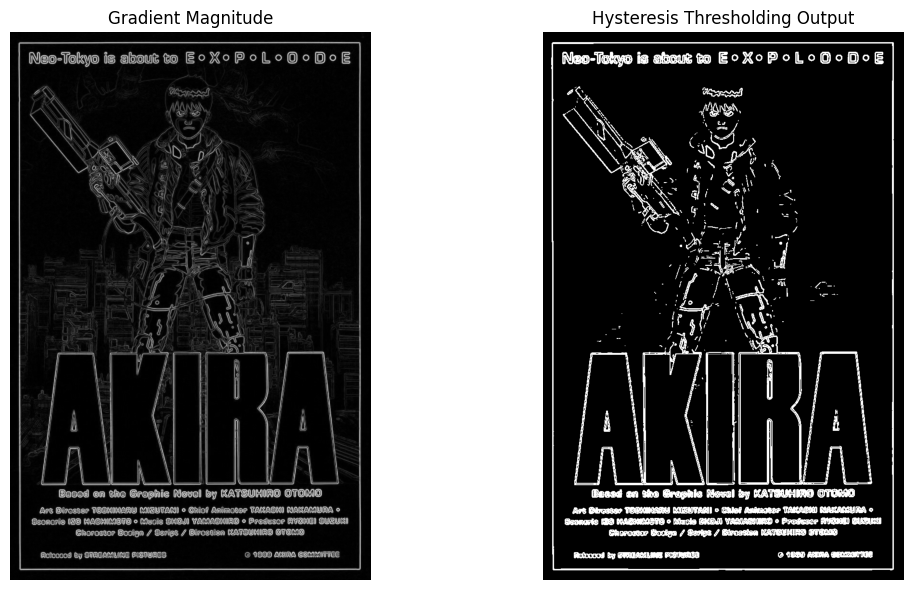

In [129]:
def exercise_2(
    magnitude: np.ndarray,
    low_threshold: int, # 0 - 255
    high_threshold: int, # 0 - 255
) -> np.ndarray:
    # <your_code_here>
    # 1
    _, strong = cv2.threshold(magnitude, high_threshold, 255, cv2.THRESH_BINARY)
    
    # 2
    _, weakFirst = cv2.threshold(magnitude, low_threshold, 255, cv2.THRESH_BINARY)
    #print(strong, weakFirst)
    _, weak = cv2.threshold(weakFirst - strong, 128, 255, cv2.THRESH_BINARY)
    
    # 3, 4
    out = np.zeros(magnitude.shape)
    for y in range(1, out.shape[0]-1):
        for x in range(1, out.shape[1]-1):
            p = weak[y][x]
            if(p > 128):
                #print("weak")
                blob = strong[y-1:y+1, x-1:x+1]
                m = np.max(blob)
                if(m > 128):
                    out[y][x] = 255
                else:
                    out[y][x] = 0
            else:
                if(strong[y][x] == 0):
                    out[y][x] = 0
                else:
                    out[y][x] = 255

    #out = weak



    # </your_code_here>
    return out

magnitude, _, _, _ = exercise_1(image_grayscale)
output = exercise_2(magnitude, 128, 255)

# Plotting the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(magnitude, cmap='gray')
axes[0].set_title('Gradient Magnitude')
axes[0].axis('off')

axes[1].imshow(output, cmap='gray')
axes[1].set_title('Hysteresis Thresholding Output')
axes[1].axis('off')

plt.tight_layout()
plt.show()
